# Fitbit Data Project: Making a prediction for the two weeks of missing data

By: Norrick McGee and Eric Escalante  
April 25, 2019  

In this Jupyter Notebook, we will use the Time Series Methology and fitbit data collected from 04/26/2018 to 12/06/2018 to predict two weeks 12/07/2019 to 12/20/2019 of missing data; we will add our pridicted data in a separate csv file.

## Imports
**Import the necessary packages and their use cases for this project:**
> **pandas:** data frames and data manipulation  
> **numpy:** summary statistics  
> **matplotlib:** used for visualizations  
> **seasborn:** fancy visualizations  
> **datetime:** turn the dates into datetime objects / get day of week  
> **warning:** used to ignore python warnings  
> **statsmodels:** library of different statistical tests we will be performing thoughout the project

In [1]:
from prepare import prepare_fitbit

import numpy as np
import pandas as pd

import os
from datetime import datetime
import itertools
 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from fbprophet import Prophet

## Table of contents
1. [Project Planning](#project-planning)
1. [Preparation](#preparation)
1. [Exploration](#exploration)
1. [Modeling](#modeling)

## Project Planning <a name="project-planning"></a>

### Goals  
> Goals for the Project are:  
1. We will predict using different Time Series Methodologies the missing two weeks of Fitbit data
2. We will show the reasoning behind our preditions with visualizations and statistical findings
3. Finally we will create a viewable csv file with those pridictions so that you could see the endire dataset

### Deliverables

> **Summarization of the data:**
> The USB thumb drive is not a Rubber Duck USB drive so our trust is still intact with the employee barged into the room. The data on the USB drive was full of FitBit data shoved into 8 CSV files. The files contained months worth of autotracked in formation by FitBit and manually tracked in formation by the Employee. The last 22 days are missing from the AutoTracked information and our job is to predict that information. As we go through the data we will want to add more columns to help us predict the missing information such as months, weeks, and day. These new columns will help us see the employees trends month over month, week over week, and day over day. In the end we will create a new CSV to add to the USB that will have the predicted information for the employee.

### Data Dictionary & Domain Knowledge

We have sixteen columns in our dataset. Let us understand what each one is. We will be adding more throughout the project.

AutoTracked information by FitBit:
>**activity_calories:** amount of calories burned from activity throughout the day  
> **distance:** distance traveled   
> **floors:** floors climbed   
> **mins_active_high:** minutes of high activity in the day   
> **mins_active_light:** minutes of light activity in the day  
> **mins_active_med:** minutes of moderate activity in the day  
> **mins_sedentary:** minutes the fit bit assums you are sitting down  
> **steps:** total amount of steps taken in a day  
> **total_calories:** total calories burned throughout the day  

Manually Tracked information by Employee:  
> **calories:** amount of calories consumed throughout the day  
> **carbs:** amount of carbs consumed throughout the day  
> **fat:** amount of fat consumed throughout the day  
> **fiber:** amount of fiber comsumed throughout the day  
> **protien:** amount of protein consumed throughout the day  
> **sodium:** amount of sodium consumed throughout the day  
> **water:** metric desplays tracked water intake or set a consumption 

### Hypotheses

> 1. The USB thumb drive contains all the FitBit auto tracking information; however the manually entered information from the daily consumption was not be filled out consistantly.
> 2. The emoloyee will have a slow start in all FitBit tracking fields, but as he/she continues to see progress they will get better as the months go on.
> 3. We will see the minutes sitting down gradually decrease over time and see their moderate to high activity increase over time.

### Thoughts & Questions

> Thoughts:  
1. We should only use our test data once
2. Make sure we are resampling the data if we wanted to to differents training models within our original train data
3. Distance has more data: maybe we use distance to equate the amount of steps
>>1 miles to steps = 2112 steps  
2 miles to steps = 4224 steps  
3 miles to steps = 6336 steps  
4 miles to steps = 8448 steps  
5 miles to steps = 10560 steps  

> Questions: 
1. Where are we going to split our times?
2. What two weeks are we predicting?
3. What is the distance formula?  
4. What does the employee's activity level look like?

## Prepare the Environment

## Preparation <a name="preparation"></a>

In [2]:
df = prepare_fitbit()

In [3]:
def add_date_parts(df):
    '''
    Function to add columns based on date: month, day of month, day of week
    '''
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['weekday'] = df.index.day_name()
    
    return df

def nulls_by_col(df):
    '''
    Funciton used to find missing information in each column
    '''
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    pct_missing = num_missing/rows
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'pct_rows_missing': pct_missing})
    
    return cols_missing

def nulls_by_row(df):
    '''
    Function used to find missing information in each row
    '''
    num_cols_missing = df.isnull().sum(axis=1)
    pct_cols_missing = df.isnull().sum(axis=1)/df.shape[1]*100
    rows_missing = pd.DataFrame({'num_cols_missing': num_cols_missing, 'pct_cols_missing': pct_cols_missing})\
                     .reset_index().groupby(['num_cols_missing','pct_cols_missing']).count()\
                     .rename(index=str, columns={'index': 'num_rows'}).reset_index()
    
    return rows_missing

def df_summary(df):
    '''
    Funciton summarizes our created data frame with information on: shape, type & null info, desribe function from pandas library, null values by column, null values by row, and value counts
    '''
    print('--- Shape: {}'.format(df.shape))
    print('--- Info')
    df.info()
    print('--- Descriptions')
    print(df.describe(include='all'))
    print('--- Nulls By Column')
    print(nulls_by_col(df))
    print('--- Nulls By Row')
    print(nulls_by_row(df))

In [4]:
df = add_date_parts(df)

In [5]:
df_summary(df)

--- Shape: (247, 19)
--- Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2018-04-26 to 2018-12-28
Data columns (total 19 columns):
activity_calories    225 non-null float64
distance             225 non-null float64
floors               225 non-null float64
mins_active_high     225 non-null float64
mins_active_light    225 non-null float64
mins_active_med      225 non-null float64
mins_sedentary       225 non-null float64
steps                225 non-null float64
total_calories       225 non-null float64
calories             247 non-null int64
carbs                247 non-null object
fat                  247 non-null object
fiber                247 non-null object
protien              247 non-null object
sodium               247 non-null object
water                247 non-null object
month                247 non-null int64
day                  247 non-null int64
weekday              247 non-null object
dtypes: float64(9), int64(3), object(7)
memory usage: 38.6+ K

**Primary focus on following columms:**
> activity_calories  
> distance  
> floors
> mins_active_high  
> mins_active_light  
> mins_active_med  
> mins_sedentary 
> steps  
> total_calories  

**Let's see where the mojority of of our data is landing _(thoughts)_**

>1. We do want to look where are current numbers land to see how we want to structure our null values
>2. Option could be just to add a zero there; reasoning could because the person forgot to log his info
>3. Could use the average because if these guys are so busy that they do not have time for side conversations they may just eat/do the same thing each day  

In [6]:
for col in df.select_dtypes('number'):
    print(f'\n- {col} -')
    print(df[col].value_counts(bins=4, sort=False))


- activity_calories -
(-3.597, 899.0]      41
(899.0, 1798.0]     113
(1798.0, 2697.0]     60
(2697.0, 3596.0]     11
Name: activity_calories, dtype: int64

- distance -
(-0.013000000000000001, 3.0]    83
(3.0, 6.0]                      88
(6.0, 9.0]                      48
(9.0, 12.0]                      6
Name: distance, dtype: int64

- floors -
(-0.196, 48.75]    216
(48.75, 97.5]        2
(97.5, 146.25]       4
(146.25, 195.0]      3
Name: floors, dtype: int64

- mins_active_high -
(-0.155, 38.5]    142
(38.5, 77.0]       43
(77.0, 115.5]      36
(115.5, 154.0]      4
Name: mins_active_high, dtype: int64

- mins_active_light -
(-0.35, 87.25]      24
(87.25, 174.5]      53
(174.5, 261.75]    121
(261.75, 349.0]     27
Name: mins_active_light, dtype: int64

- mins_active_med -
(-0.079, 19.5]    161
(19.5, 39.0]       45
(39.0, 58.5]       15
(58.5, 78.0]        4
Name: mins_active_med, dtype: int64

- mins_sedentary -
(26.587, 381.0]       1
(381.0, 734.0]      102
(734.0, 1087.0] 

**_Thoughts:_**
> We are going to try and use Facebooks Prophet to generate quick time series data to fill missing values

## Exploration  <a name="exploration"></a>

In [7]:
def createheatmap(df):
    '''
    Function we will use to create heatmaps with pretty specific parameters that keep these heatmaps uniform
    '''
    sns.set(style = "white")
    corrd = df.corr()
    mask = np.zeros_like(corrd, dtype=np.bool)    ### returns an array of zerros for NA's to fill each column; ensures each column is the same shape
    mask[np.triu_indices_from(mask)] = True       ### returns the indices for the upper-triangle of an (n, m) array.
    f, ax = plt.subplots(figsize=(15, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corrd, mask=mask, cmap=cmap, square=True, 
                xticklabels=True, yticklabels=True, 
                linewidths=.5, ax=ax)

def bin_feature(df, col, newcol, bin_cuts=[]):
    '''
    Function we will use to bin different columns during our exploration -> returns the dataframe with the column binned 
    '''
    labs = list(range(len(bin_cuts)))[1:]
    df[newcol] = pd.cut(df[col], bin_cuts, labels=labs, include_lowest=False)
    
    return df

def summary_stat(df, col_name):
    '''
    Function to provide median, min, and max of data in column -> returns a new small dataframe with the info
    '''
    df = pd.DataFrame({'Mean ' : str(round(np.mean(df[col_name]),2)),
         'Median' : str(np.median(df[col_name])),
         'Min' : str(np.min(df[col_name])),
         'Max' : str(np.max(df[col_name]))}, index=[0])
    
    return df

**_Thoughts:_**
> We want to see how each month looks stacked up together using the distance metric  
> We want to get a total amount so that we can potentially look at the rolling average  
> Instead of the distance we really do want to use **step count**  
> From here on out we want to aggregate by the mean

**Let's create a stacked bar plot to see a breakdown of activity levels by month**

In [8]:
df['month_named'] = df['month'].astype('str')
df.loc[df['month_named'] == '4','month_named'] = 'APR'
df.loc[df['month_named'] == '5','month_named'] = 'MAY'
df.loc[df['month_named'] == '6','month_named'] = 'JUN'
df.loc[df['month_named'] == '7','month_named'] = 'JLY'
df.loc[df['month_named'] == '8','month_named'] = 'AUG'
df.loc[df['month_named'] == '9','month_named'] = 'SEP'
df.loc[df['month_named'] == '10','month_named'] = 'OCT'
df.loc[df['month_named'] == '11','month_named'] = 'NOV'
df.loc[df['month_named'] == '12','month_named'] = 'DEC'

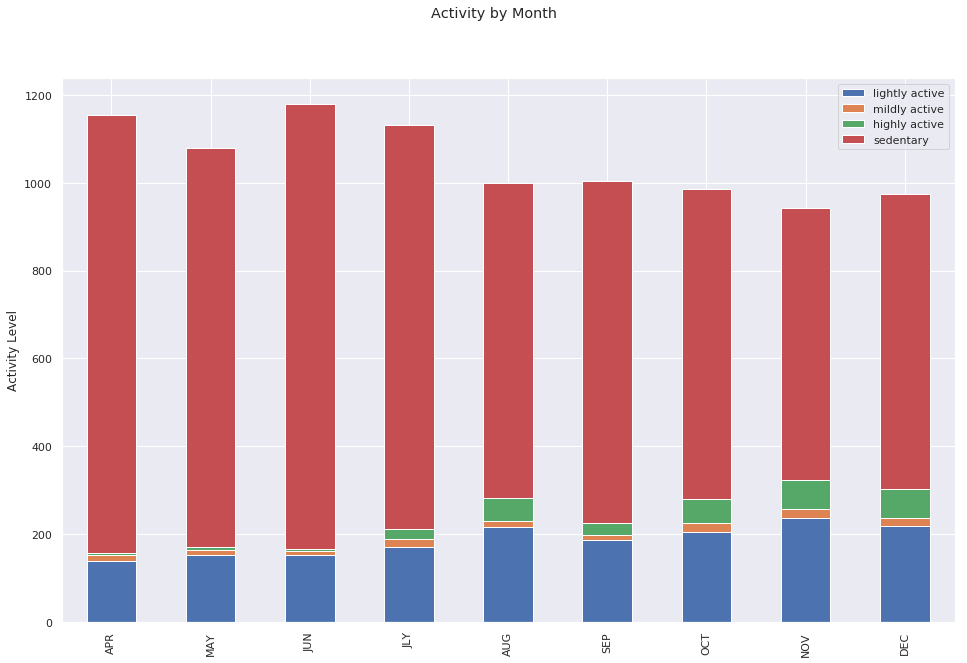

In [9]:
sns.set()
df[['mins_active_light','mins_active_med','mins_active_high','mins_sedentary']].sort_index().rename(columns={'mins_active_light':'lightly active','mins_active_med':'mildly active','mins_active_high':'highly active','mins_sedentary':'sedentary'}).groupby(df.month_named,sort=False).mean().plot(kind='bar',stacked=True, figsize = (16,10))
plt.title('')
plt.suptitle('Activity by Month')
plt.ylabel('Activity Level')
plt.xlabel('')

df.drop(columns='month_named',inplace=True)

**Let's create a line graph so we can see the trends of the amount of steps**

Text(0.5, 1.0, 'Steps Trend for Employee')

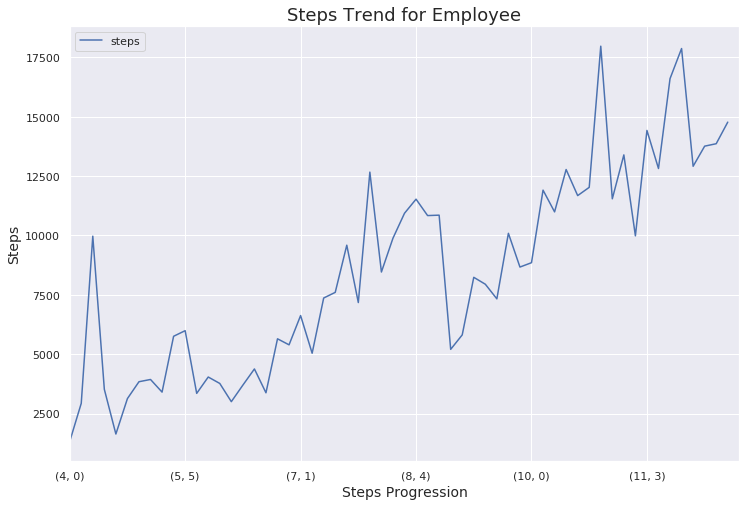

In [10]:
df_distance = df[['steps']].groupby([(df.index.month),(df.index.weekday)]).mean()
df_distance[:59].plot(figsize=(12,8))
plt.ylabel('Steps', fontsize=14)
plt.xlabel('Steps Progression', fontsize=14)
plt.title('Steps Trend for Employee', fontsize=18)

**_Thoughts:_**
> Here we want to see if the total distance traveled has a trend by month  
> This person had a peak in distance traveled in November; he must have just gotten the FitBit in April  
> We can also add steps once we fill all missing values


**Let's graph a boxplot so we can see the information in Monthly Steps regarding the shape, variability, and center (or median) of monthly distance**

Text(0.5, 0, 'Month')

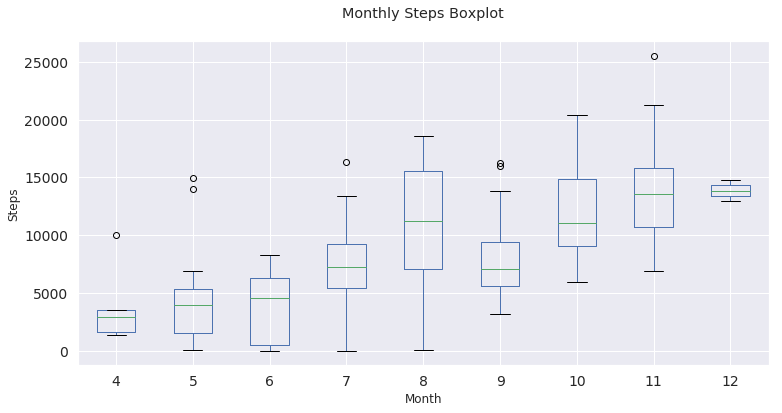

In [11]:
df.boxplot(column = 'steps', by = 'month', figsize=(12,6))

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.title('')
plt.suptitle('Monthly Steps Boxplot')
plt.ylabel('Steps')
plt.xlabel('Month')

**_Thoughts:_**
> Individuals walked distance increased significantly in August  
> His/Her distance remained stable in November and December. However, in May through August, it rose suddenly  
> In August and September, there was a sudden drop in distance  
> The FitBit manually tracks Steps and we can use this information to predict the missing two weeks later on

**Let's graph a boxplot so we can see the information in Active Calories regarding the shape, variability, and center (or median) of monthly distance**

Text(0.5, 0, 'Month')

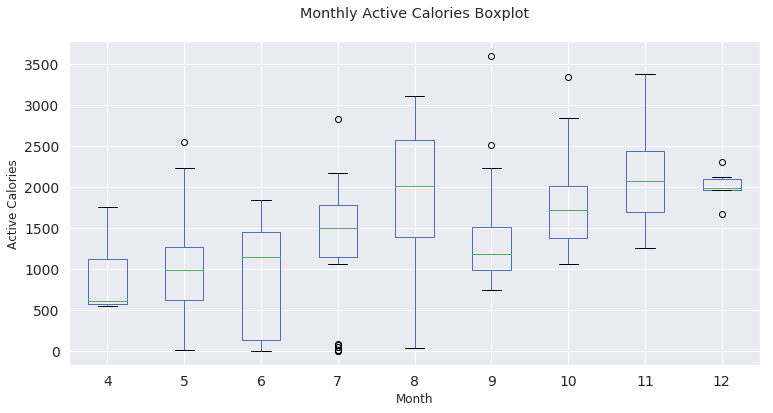

In [12]:
df.boxplot(column = 'activity_calories', by = 'month', figsize=(12,6))

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.title('')
plt.suptitle('Monthly Active Calories Boxplot')
plt.ylabel('Active Calories')
plt.xlabel('Month')

**_Thoughts:_**
> The employee's Active Calorie Boxplot closely resembles the Steps Boxplot  
> We can see if the two features has a strong correlation  
> The FitBit manually tracks Active Calories and we can use this information to predict the missing two weeks later on

**Let's looks at all the feature correlations from the FitBit USB we found**

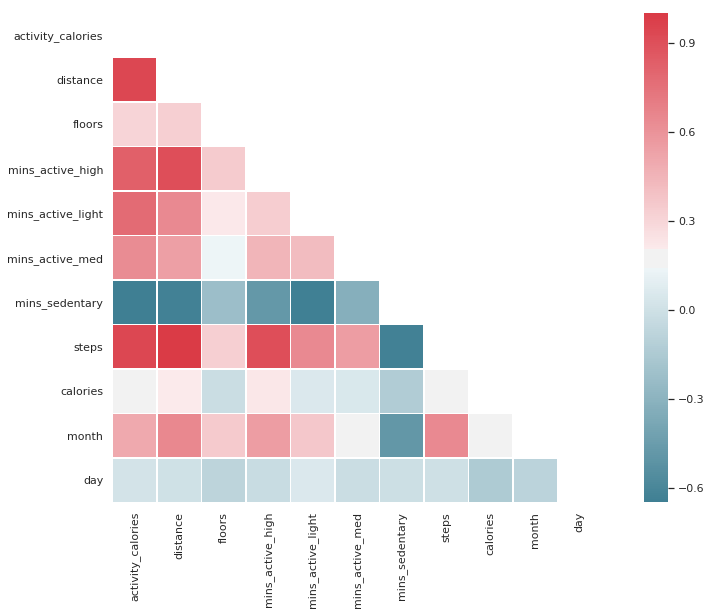

In [13]:
createheatmap(df.drop(columns=['total_calories']))

**_Thoughts_**
> The strongest correlations in the heatmap are between activity_calories and distance; also between distance and steps
> There are no missing values in this correlation matrix; besides the two weeks we are going to predict  
> Which variables are we going to start binning? Will we do any actual binning?  
> Which statistical results are we going to start preparing for?

### Train-Test Split

 > We will be using the Prophet Modeling Method  
 > We first want to see the models predicctions for distance during the two week period

In [14]:
df['ds'] = df.index
df['y'] = df.distance    ### Later we will add all y variables

m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.3)
m.fit(df)

forecast = m.predict(df)
print('\n')
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(22))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.




            ds      yhat  yhat_lower  yhat_upper
225 2018-12-07  7.277097    5.138433    9.321034
226 2018-12-08  7.842637    5.824248   10.054928
227 2018-12-09  8.063297    5.974295   10.127443
228 2018-12-10  6.945631    4.689465    8.995474
229 2018-12-11  7.332911    5.250117    9.332782
230 2018-12-12  7.314837    5.182390    9.354641
231 2018-12-13  8.065574    5.922814   10.112745
232 2018-12-14  8.254123    6.451239   10.314573
233 2018-12-15  8.723986    6.656883   10.845100
234 2018-12-16  8.830868    6.639574   10.858768
235 2018-12-17  7.584320    5.319272    9.620023
236 2018-12-18  7.831016    5.816444    9.776884
237 2018-12-19  7.664380    5.603063    9.649405
238 2018-12-20  8.262517    6.075446   10.382975
239 2018-12-21  8.298485    6.154473   10.433616
240 2018-12-22  8.619846    6.486349   10.552229
241 2018-12-23  8.586258    6.594840   10.647100
242 2018-12-24  7.211010    5.168054    9.429245
243 2018-12-25  7.344199    5.347162    9.573576
244 2018-12-26  7.

### Visualizations

**Let's vizualize using Prophet’s plot components (built in function)**

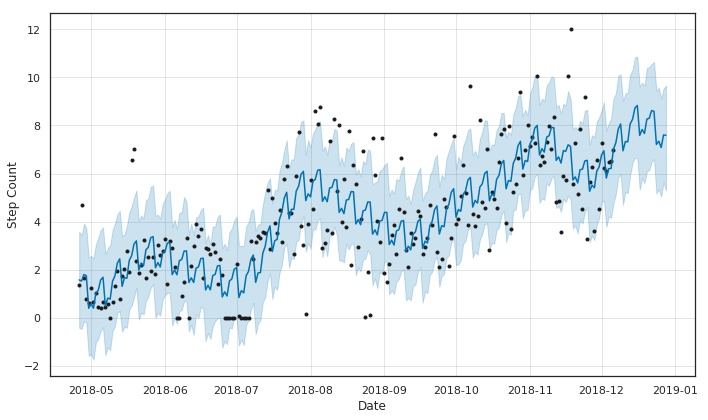

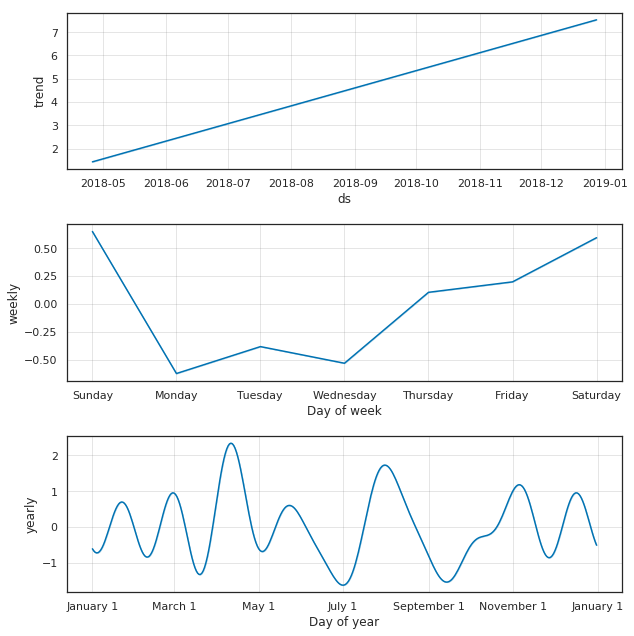

In [15]:
fig1 = m.plot(forecast)
plt.ylabel('Step Count', fontsize=12)
plt.xlabel('Date', fontsize=12)


fig2 = m.plot_components(forecast)

### Statistical Tests

**Let's evaluate using Prophet’s cross validation (built in function)**

INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00


    horizon       mse      rmse       mae       mape  coverage
92   3 days  6.253897  2.500779  2.095461  10.950124  0.476190
63   4 days  6.464450  2.542528  2.145532  10.999535  0.428571
153  4 days  6.423657  2.534493  2.106863  10.993694  0.428571
33   4 days  5.895669  2.428100  2.050923   2.596820  0.428571
183  4 days  5.500287  2.345269  1.957331   2.585991  0.476190


    horizon       mse      rmse       mae      mape  coverage
89  30 days  5.867128  2.422216  1.797484  0.325052  0.619048
149 30 days  6.043624  2.458378  1.838552  0.330619  0.571429
59  30 days  5.926390  2.434418  1.783449  0.310083  0.571429
119 30 days  6.390417  2.527927  1.883604  0.341438  0.523810
209 30 days  4.194918  2.048150  1.569243  0.315791  0.571429




Text(0, 0.5, 'Mean Squared Error')

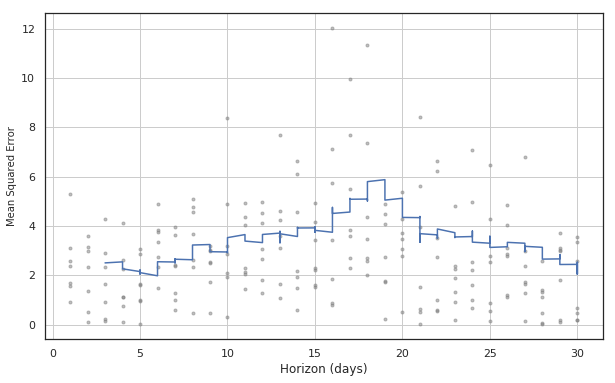

In [16]:

from fbprophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(m, horizon='30 days')

df_p = pd.DataFrame(performance_metrics(df_cv))
print(df_p.head(5))
print('\n')
print(df_p.tail(5))
print('\n')

### Evaluation using Prophet’s cross validation plot (built in function)
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

fig3 = plot_cross_validation_metric(df_cv, metric='rmse')
plt.ylabel('Mean Squared Error', fontsize=10)

### Summarize Conclusions

**Statistical Findings:**


## Modeling <a name="modeling"></a>

### Prophet Model
**_Objective:_**
> Build a model that will predict data from 12/07 to 12/28  
> We will first be using a Prophet model: https://facebook.github.io/prophet/docs/quick_start.html  
> Prophet only takes data as a dataframe with a ds (datestamp) and y (value we want to forecast) column  
> We will be creating a new dataframe that we can export to a CSV file

### Test Model

**_Objectives_**
> 1. We will create a dataframe that contains our predictions  
> 2. With the Prophet Model we will be loop through each independed feature to create multiple models using different features 
> 3. With the yhat of each model we will be creating a new column in our Prophet dataframe

In [17]:
def prophesize(df,column_name):
    '''
    Function that creates different Prophet models using all 'AutoTracked' independent features; it will return a dataframe with all 'yhats' added together as columns
    '''
    df['ds'] = df.index
    df['y'] = df[column_name]

    m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.3)
    m.fit(df)

    forecast = m.predict(df)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    forecast[column_name+'_yhat'] = forecast['yhat']

    
    return forecast[['ds',column_name+'_yhat']]

In [18]:
cols = ['activity_calories', 'distance', 'floors', 'mins_active_high',
       'mins_active_light', 'mins_active_med', 'mins_sedentary', 'steps',
       'total_calories']
proph_dfs = []

for col in cols:
    proph_dfs.append(prophesize(df,col))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
proph_df = proph_dfs[0]
for proph in proph_dfs[1:]:
    
    proph_df = pd.merge(proph_df,proph)

**Let's print out the two weeks of missing data our employee was requesting**

In [20]:
proph_df[-22:-8]

,ds,activity_calories_yhat,distance_yhat,floors_yhat,mins_active_high_yhat,mins_active_light_yhat,mins_active_med_yhat,mins_sedentary_yhat,steps_yhat,total_calories_yhat
225,2018-12-07,2232.731653,7.277097,19.689235,80.771932,211.889097,14.341044,676.692998,15494.562887,3610.049716
226,2018-12-08,2380.458035,7.842637,20.709134,86.946296,221.667476,20.323848,572.481190,16538.007394,3672.890863
227,2018-12-09,2477.808915,8.063297,27.565841,91.639487,231.490606,20.627395,536.676977,17230.110495,3638.354478
228,2018-12-10,2058.188715,6.945631,11.425569,76.610530,192.541840,9.994397,621.561686,14977.156406,3282.475394
229,2018-12-11,2140.696249,7.332911,14.874814,83.220978,198.722417,7.767454,652.548561,15865.154253,3306.136205
230,2018-12-12,2143.662702,7.314837,13.921229,83.349955,192.095548,8.812028,696.766130,15868.339982,3228.960276
231,2018-12-13,2370.084246,8.065574,14.805666,94.893815,208.701450,9.455167,651.528727,17383.307136,3352.412771
232,2018-12-14,2433.977634,8.254123,13.086203,102.746757,199.790540,14.379292,629.774690,17857.764313,3355.293559
233,2018-12-15,2555.838524,8.723986,15.201122,106.896363,212.848125,20.547476,520.999297,18671.618850,3404.167560
234,2018-12-16,2622.822988,8.830868,23.203910,109.182662,226.068182,21.007214,481.105383,19092.045896,3360.830875


### Prophet to CSV 

In [21]:
### proph_df[-22:-8].to_csv('filename.csv')

### Summarize Conclusions

**Summary:**
> We have predicted the missing two weeks of information, created a CSV and added it to the USB thumb drive. 

### Find different ways to improve:

**Group By: Workday hours, Non workday hours, Weekend hours_**
> **This will help estimate who the USB belongs to** 


> Can we create two seperate df for each test  
> New df's will include:
> 1. Different days of the week to see when the employee works
> 2. Different hours to match the different schedules Big Research Co offeres  
> 3. Group by weekends to spot out trends of activity on the weekend; especially during company events